This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


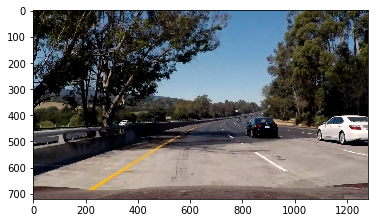

In [4]:
# the first thing you'll do is to compute the camera calibration matrix and distortion coefficients. You only need to compute these once, and then you'll apply them to undistort each new frame. 
#Next, you'll apply thresholds to create a binary image and then apply a perspective transform.
 

# find lanes: color - . It's most important that you reliably detect different colors of lane lines under varying degrees of daylight and shadow.

#apply a perspective transform. for calculating curve
# histogram + sliding window to find polyfit

#test a image
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline
#reading in an image
test_image = mpimg.imread('test_images/test5.jpg')

#printing out some stats and plotting
print('This image is:', type(test_image), 'with dimensions:', test_image.shape)
plt.imshow(test_image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')


In [5]:
#1.calibrate your camera and undistort,
['calibration1.jpg']
calibration_images = glob.glob('camera_cal/calibration*.jpg')

nx = 9
ny = 6


objpoints = []
imgpoints = []
gray_shape = None
for fname in calibration_images:
    calibration = mpimg.imread(fname)
    gray = cv2.cvtColor(calibration, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret == True:
        imgpoints.append(corners)
        objp = np.zeros((ny * nx, 3), np.float32)
        # plt.imshow(calibration)
        gray_shape = gray.shape[::-1]
        # z stays zero, x and y cordinates turns to point index
        objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
        objpoints.append(objp)
    #     img = cv2.drawChessboardCorners(calibration, (nx,ny), corners, ret)
    #     plt.imshow(img)
    else:
        print('not found corners',fname)


ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray_shape, None, None)

# test_image = mpimg.imread('camera_cal/calibration3.jpg')
# dst = cv2.undistort(test_image, mtx, dist, None, mtx)
# plt.imshow(dst)

not found corners camera_cal/calibration1.jpg
not found corners camera_cal/calibration4.jpg
not found corners camera_cal/calibration5.jpg


In [17]:
#undistort an test image, 

def undistort_threshold_image(test_image, show_output = False):
    undistort_test_image = cv2.undistort(test_image, mtx, dist, None, mtx)
    #apply thresholds to create a binary image 
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(undistort_test_image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    gray = cv2.cvtColor(undistort_test_image, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    # color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    
    # ax1.set_title('Stacked thresholds')
    # ax1.imshow(color_binary)
    #### mask
    y_boundary = 450
    height, width = combined_binary.shape
    mask_vertices = [[160,height],[585,y_boundary], [690,y_boundary],[1230,height]]
    
    #apply a perspective transform.
    transform_src = np.float32(mask_vertices)
    transform_dst = np.float32([[0,height],[0,0],[width,0],[width,height]])

    M = cv2.getPerspectiveTransform(transform_src, transform_dst)
    binary_warped = cv2.warpPerspective(combined_binary, M, (width,height), flags=cv2.INTER_LINEAR)

    if show_output:
        # Plotting thresholded images
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('Combined S channel and gradient thresholds')
        # interest = region_of_interest(combined_binary,mask_vertices)
        ax1.imshow(combined_binary, cmap='gray')

        ax2.imshow(binary_warped)
        ax2.set_title('Undistorted and Warped Image')
    return binary_warped, undistort_test_image, M, height, width


In [13]:
# test_image = mpimg.imread('test_images/test5.jpg')
# undistort_test_image = undistort_threshold_image(test_image)

# # map polyfit to original image
# inverted_binary_warped = cv2.warpPerspective(out_img, M, (width,height), flags=cv2.WARP_INVERSE_MAP)
# # plt.imshow(inverted_binary_warped)

# stacked_out_image = np.dstack(( undistort_test_image[:,:,0], np.maximum(undistort_test_image[:,:,1], inverted_binary_warped[:,:,1]),undistort_test_image[:,:,2]))
# # stacked_image = np.concatenate((undistort_test_image, inverted_binary_warped), axis=0)
# plt.imshow(stacked_out_image)
# # print(undistort_test_image[0])

In [14]:
#locate lane lines

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    left_pts = np.array([[[xi, yi]] for xi, yi in zip(left_fitx, ploty) ]).astype(np.int32)
    right_pts = np.array([[[xi, yi]] for xi, yi in zip(right_fitx, ploty) ]).astype(np.int32)
    right_pts = np.flipud(right_pts)
    points = np.concatenate((left_pts, right_pts))
    cv2.fillPoly(out_img, [points], color=[0,255,0])
    return out_img, points




In [22]:
def process_image(image, show = False):
#     test_image = mpimg.imread('test_images/test5.jpg')
    binary_warped, undistort_test_image, M, height, width = undistort_threshold_image(image)
    out_img, points = fit_polynomial(binary_warped)

    # map polyfit to original image
    inverted_binary_warped = cv2.warpPerspective(out_img, M, (width,height), flags=cv2.WARP_INVERSE_MAP)
    # plt.imshow(undistort_test_image)

    stacked_out_image = np.dstack(( undistort_test_image[:,:,0], np.maximum(undistort_test_image[:,:,1], inverted_binary_warped[:,:,1]),undistort_test_image[:,:,2]))
    if show:
        plt.imshow(stacked_out_image)
    return stacked_out_image

In [26]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
#apply to video
video_name = 'challenge_video.mp4' #project_video.mp4

white_output = 'test_videos_output/'+ video_name
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip(video_name).subclip(0,10)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_video.mp4
[MoviePy] Writing video test_videos_output/challenge_video.mp4


100%|██████████| 300/300 [01:08<00:00,  4.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video.mp4 

CPU times: user 39 s, sys: 1.46 s, total: 40.5 s
Wall time: 1min 11s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
# defects: manually defining src and dst perspective transoform not reliable, depends on 
TODO
1. put all out put image into folders, like example folder
2. why some images only have lanes up to half image, some of them are missing points which leads to fit errors